<a href="https://colab.research.google.com/github/FeixianWu/Leetcode_Bootcamp/blob/main/test2_datamapplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tail-Dependence Clustering:   

*   Technique: Focuses on the co-movement of assets during extreme market events.
*   Process: Estimate tail dependence coefficients using extreme value theory, then cluster based on these coefficients.  
*   Significance: Crucial for managing tail risk in portfolios, stress testing, and designing hedging strategies.


In [1]:
pip install DataMapPlot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 27.4 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5969 sha256=d2ab13acc2f15c1af27fd3aebdfbe54679314b22fbf304db3407fd4eab3f5090
  Stored in directory: /root/.cache/pip/wheels/63/e6/90/6e15bfb4299fd41f88a9affca879f44bde40d3dc6f398462a8
Successfully built Pyqtree
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [2]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 17.0 MB/s eta 0:00:00


In [3]:
pip install pycopula

In [4]:
import pandas as pd
import numpy as np

import yfinance as yf
import statsmodels.api as sm
import datamapplot
from arch import arch_model
from scipy.stats import rankdata
from pycopula.copula import ArchimedeanCopula
from scipy.stats import spearmanr
from sklearn.manifold import MDS

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

In [5]:
close_prices = pd.read_parquet("https://storage.googleapis.com/sovai-public/prices/prices_closeadj.parq")
# close_prices.reset_index(inplace=True)
close_prices

closeadj
ticker date                 
A      1999-11-18  26.917000
       1999-11-19  24.702999
       1999-11-22  26.917000
       1999-11-23  24.622999
       1999-11-24  25.118999
...                      ...
NaN    2024-07-10   0.428000
       2024-07-11   0.420000
       2024-07-12   0.410000
       2024-07-15   0.403000
       2024-07-16   0.403000

[43688696 rows x 1 columns]

In [6]:
df_unstack = close_prices[close_prices.index.get_level_values('ticker').notna()]
df_unstack = df_unstack["closeadj"].unstack(level='ticker')
df_unstack = df_unstack.pct_change(fill_method=None).dropna(axis=0,how="all")
df_unstack.reset_index(inplace=True)
df_unstack

ticker,date,A,A1,AA,AAAB,AAAGY,AAAP,AAB,AABC,AAC,...,ZWRK,ZWRKU,ZWRKW,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYXI,ZZ
0,1998-01-02,NaN,0.000000,NaN,NaN,NaN,NaN,-0.007576,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-01-05,NaN,0.036304,NaN,NaN,NaN,NaN,0.045802,-0.022663,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998-01-06,NaN,-0.020997,NaN,NaN,NaN,NaN,-0.003679,0.011595,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-01-07,NaN,0.017892,NaN,NaN,NaN,NaN,0.011019,0.045944,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-01-08,NaN,0.007042,NaN,NaN,NaN,NaN,0.003594,-0.032968,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6671,2024-07-10,0.013156,NaN,-0.046368,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.019923,NaN,NaN,-0.011765,NaN,0.026286,NaN
6672,2024-07-11,0.029511,NaN,0.018721,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.028101,NaN,NaN,0.068182,NaN,0.043430,NaN
6673,2024-07-12,0.010778,NaN,-0.005870,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.010333,NaN,NaN,0.020263,NaN,0.007471,NaN
6674,2024-07-15,-0.009226,NaN,0.008986,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.013527,NaN,NaN,0.019861,NaN,-0.004237,NaN


In [7]:
start_date, end_date = '2014-01-01','2024-01-01'
df_unstack_selected = df_unstack[(df_unstack['date'] >= start_date) & (df_unstack['date'] <= end_date)]

# Find valid tickers with no missing values throughout the period
valid_tickers = df_unstack_selected.loc[:, df_unstack_selected.notna().all()].columns

# Select only the valid tickers
df_final = df_unstack_selected[valid_tickers]

# Now df_final is ready for further analysis
df_final

ticker,date,A,AACG,AAL,AAMC,AAME,AAOI,AAON,AAP,AAPL,...,ZBH,ZBRA,ZD,ZEUS,ZG,ZION,ZTS,ZUMZ,ZWS,ZYXI
4025,2014-01-02,-0.017120,-0.017203,0.004370,-0.007367,-0.026488,-0.025316,-0.008110,-0.008495,-0.014042,...,-0.010190,-0.016642,-0.007404,-0.009313,0.003924,-0.010371,-0.010103,0.008077,0.004043,-0.030702
4026,2014-01-03,0.012633,-0.003044,0.046520,0.001668,0.022360,-0.019139,-0.000382,0.028617,-0.022000,...,0.004338,0.007522,0.000615,0.010812,-0.002071,0.007084,-0.009572,-0.002289,0.012158,0.000000
4027,2014-01-06,-0.004937,0.003054,0.018468,-0.014664,-0.011067,-0.001394,-0.016053,-0.009564,0.005446,...,0.006473,-0.003359,-0.002218,-0.006212,0.069834,-0.007034,-0.002189,-0.005736,0.033206,-0.027149
4028,2014-01-07,0.014298,0.017504,-0.004631,0.023453,0.003730,0.028611,0.014450,0.012338,-0.007124,...,0.019951,0.010300,0.012721,0.021490,0.032985,0.003060,0.003746,0.023077,0.004591,0.060465
4029,2014-01-08,0.016385,0.009723,0.026972,-0.003216,-0.007433,-0.005427,0.004365,-0.007770,0.006345,...,0.024495,-0.000741,0.013936,-0.015932,-0.014354,0.008734,-0.011197,-0.015789,-0.024915,0.052631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,2023-12-22,0.004529,0.003704,-0.002787,-0.006849,0.049699,0.007715,0.014078,0.009232,-0.005547,...,0.007609,0.015454,0.012662,0.011915,0.001725,0.008712,0.001642,0.002547,0.009796,0.008531
6537,2023-12-26,0.001721,0.031980,-0.013976,-0.032184,-0.009565,0.091866,0.010088,-0.005400,-0.002843,...,0.009121,0.022605,0.004266,0.015490,-0.005338,0.020000,0.002670,0.006098,0.007318,0.006579
6538,2023-12-27,0.000072,0.251490,-0.008505,0.076010,0.033800,-0.013146,0.000811,0.010509,0.000519,...,-0.002390,0.001053,-0.000293,0.001918,0.012985,-0.008244,0.007162,0.008586,-0.007598,0.005602
6539,2023-12-28,-0.000359,0.085714,-0.000715,-0.024283,0.018216,-0.027531,0.000270,-0.001134,0.002227,...,0.004128,-0.001595,0.004103,-0.005860,-0.011793,0.003370,0.001317,0.025038,-0.008697,0.011142


Step 1: Calculate Tail Dependence Coefficients & Step 2: Create the Dissimilarity Matrix

In [8]:
# Function to calculate Spearman correlation using ranks and Pearson correlation
def spearman_correlation(data):
    ranks = np.apply_along_axis(rankdata, 0, data)
    corr_matrix = np.corrcoef(ranks, rowvar=False)
    return corr_matrix

# Assuming df_final has the correct format with returns data
data_array = df_final.iloc[:, 1:].values  # exclude date column

# Calculate Spearman correlation matrix using ranks
tail_matrix = spearman_correlation(data_array)

# Convert to dissimilarity matrix
dissimilarity_matrix = -np.log(np.abs(tail_matrix) + np.finfo(float).eps)
np.fill_diagonal(dissimilarity_matrix, 0)
dissimilarity_matrix


array([[0.        , 2.76415705, 1.09400259, ..., 1.33898052, 0.69977614,
        1.97734722],
       [2.76415705, 0.        , 2.23779453, ..., 2.92830923, 3.00449796,
        3.63884284],
       [1.09400259, 2.23779453, 0.        , ..., 1.08175602, 0.91863353,
        2.33220626],
       ...,
       [1.33898052, 2.92830923, 1.08175602, ..., 0.        , 0.97910354,
        2.38292244],
       [0.69977614, 3.00449796, 0.91863353, ..., 0.97910354, 0.        ,
        2.28985656],
       [1.97734722, 3.63884284, 2.33220626, ..., 2.38292244, 2.28985656,
        0.        ]])

Step 3: Apply Multidimensional Scaling (MDS)-6mins

In [9]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=-1)
mds_coords = mds.fit_transform(dissimilarity_matrix)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [10]:
mds_coords

array([[-0.11249661, -0.49761084],
       [-2.4267851 ,  1.35378259],
       [-0.0364372 ,  0.35047638],
       ...,
       [ 0.53739759,  0.5873938 ],
       [ 0.11501318, -0.01276804],
       [-0.89658426, -1.87209312]])

Step 4: Clustering with k-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

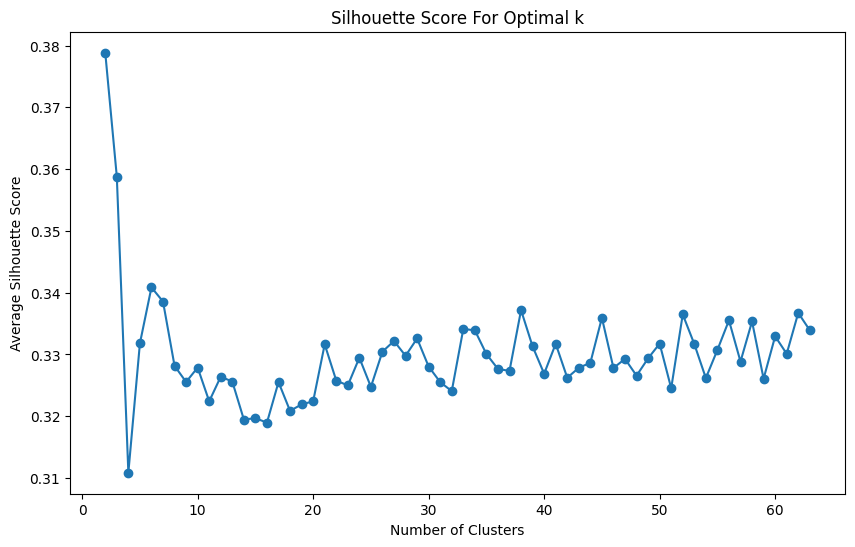

In [11]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

range_n_clusters = list(range(1, 64))
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(mds_coords)
    if num_clusters > 1:
        silhouette_avg.append(silhouette_score(mds_coords, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters[1:], silhouette_avg, marker='o')  # Start from 2 clusters
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

In [12]:
tickers = df_final.columns[1:]
kmeans = KMeans(n_clusters=38, random_state=42)  # You may need to optimize the number of clusters
clusters = kmeans.fit_predict(mds_coords)

# Add cluster labels back to the tickers
cluster_labels = pd.Series(clusters, index=tickers)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
print(len(cluster_labels))


2860


Visualization

mean and variance

In [14]:


# Assuming 'clusters' is a Series with index as tickers and values as cluster labels
# 'df_final' is your DataFrame with returns data, columns are tickers

# Calculate mean returns and volatility for each ticker
df_tickers = df_final.drop(['date'], axis=1)
mean_returns = df_tickers.mean()
volatility = df_tickers.std()

# # Summarize the data by clusters
# cluster_summary = pd.DataFrame({
#     'Mean Return': mean_returns,
#     'Volatility': volatility,
#     'Cluster': clusters
# }).groupby('Cluster').mean()

# # Plotting
# fig, ax1 = plt.subplots(figsize=(10, 6))

# color = 'tab:blue'
# ax1.set_xlabel('Cluster')
# ax1.set_ylabel('Mean Return', color=color)
# ax1.bar(cluster_summary.index, cluster_summary['Mean Return'], color=color, alpha=0.6)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.set_ylabel('Volatility', color=color)
# ax2.plot(cluster_summary.index, cluster_summary['Volatility'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Cluster Summary of Mean Returns and Volatility')
# plt.show()


datamapplot

In [15]:
df_tickers

ticker,A,AACG,AAL,AAMC,AAME,AAOI,AAON,AAP,AAPL,AAT,...,ZBH,ZBRA,ZD,ZEUS,ZG,ZION,ZTS,ZUMZ,ZWS,ZYXI
4025,-0.017120,-0.017203,0.004370,-0.007367,-0.026488,-0.025316,-0.008110,-0.008495,-0.014042,-0.005398,...,-0.010190,-0.016642,-0.007404,-0.009313,0.003924,-0.010371,-0.010103,0.008077,0.004043,-0.030702
4026,0.012633,-0.003044,0.046520,0.001668,0.022360,-0.019139,-0.000382,0.028617,-0.022000,0.015341,...,0.004338,0.007522,0.000615,0.010812,-0.002071,0.007084,-0.009572,-0.002289,0.012158,0.000000
4027,-0.004937,0.003054,0.018468,-0.014664,-0.011067,-0.001394,-0.016053,-0.009564,0.005446,-0.003137,...,0.006473,-0.003359,-0.002218,-0.006212,0.069834,-0.007034,-0.002189,-0.005736,0.033206,-0.027149
4028,0.014298,0.017504,-0.004631,0.023453,0.003730,0.028611,0.014450,0.012338,-0.007124,0.011390,...,0.019951,0.010300,0.012721,0.021490,0.032985,0.003060,0.003746,0.023077,0.004591,0.060465
4029,0.016385,0.009723,0.026972,-0.003216,-0.007433,-0.005427,0.004365,-0.007770,0.006345,-0.017177,...,0.024495,-0.000741,0.013936,-0.015932,-0.014354,0.008734,-0.011197,-0.015789,-0.024915,0.052631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,0.004529,0.003704,-0.002787,-0.006849,0.049699,0.007715,0.014078,0.009232,-0.005547,-0.004377,...,0.007609,0.015454,0.012662,0.011915,0.001725,0.008712,0.001642,0.002547,0.009796,0.008531
6537,0.001721,0.031980,-0.013976,-0.032184,-0.009565,0.091866,0.010088,-0.005400,-0.002843,0.017227,...,0.009121,0.022605,0.004266,0.015490,-0.005338,0.020000,0.002670,0.006098,0.007318,0.006579
6538,0.000072,0.251490,-0.008505,0.076010,0.033800,-0.013146,0.000811,0.010509,0.000519,-0.007409,...,-0.002390,0.001053,-0.000293,0.001918,0.012985,-0.008244,0.007162,0.008586,-0.007598,0.005602
6539,-0.000359,0.085714,-0.000715,-0.024283,0.018216,-0.027531,0.000270,-0.001134,0.002227,0.004399,...,0.004128,-0.001595,0.004103,-0.005860,-0.011793,0.003370,0.001317,0.025038,-0.008697,0.011142


In [16]:
annual_mean_returns = df_tickers.mean() * 252
annual_return_variance = df_tickers.var() * 252

In [17]:
df1 = pd.DataFrame(df_final.columns, columns=['Stock_Symbols'])
df1['Returns'] = annual_mean_returns
df1['Variances'] = annual_return_variance
df1.drop(columns=['Stock_Symbols'], axis=1, inplace=True)
df1

,Returns,Variances
ticker,,
A,0.164406,0.068679
AACG,1.114029,10.003536
AAL,0.069553,0.253923
AAMC,-0.026736,0.892655
AAME,0.186922,0.528997
...,...,...
ZION,0.132311,0.144229
ZTS,0.220367,0.066077
ZUMZ,0.103946,0.255980


In [18]:
df1['Cluster'] = clusters
df1

,Returns,Variances,Cluster
ticker,,,
A,0.164406,0.068679,10
AACG,1.114029,10.003536,17
AAL,0.069553,0.253923,29
AAMC,-0.026736,0.892655,23
AAME,0.186922,0.528997,28
...,...,...,...
ZION,0.132311,0.144229,29
ZTS,0.220367,0.066077,10
ZUMZ,0.103946,0.255980,4


In [19]:
# Calculate the mean return for each ticker
mean_returns = df1.mean()

# Assuming 'clusters' is a Series with cluster labels for each ticker
cluster_groups = df1.groupby(cluster_labels)

# Determine the centroid of each cluster
cluster_centroids = cluster_groups.mean()

# Find the ticker closest to the centroid of each cluster
representative_tickers = {}
for cluster_id, centroid in cluster_centroids.iterrows():
    distances = cluster_groups.get_group(cluster_id).subtract(centroid).pow(2).sum(axis=1).pow(0.5)
    representative_tickers[cluster_id] = distances.idxmin()

print(representative_tickers)

{0: 'COSM', 1: 'OSIS', 2: 'TAOP', 3: 'BIMI', 4: 'DIN', 5: 'ARTNA', 6: 'XNCR', 7: 'NTZ', 8: 'STNG', 9: 'MHH', 10: 'CNMD', 11: 'GOOD', 12: 'PZZA', 13: 'CLNE', 14: 'PFIS', 15: 'BYRN', 16: 'SENEA', 17: 'OBLG', 18: 'PANL', 19: 'ENSV', 20: 'RDIB', 21: 'BGFV', 22: 'EML', 23: 'THTX', 24: 'AIV', 25: 'FUSB', 26: 'ACST', 27: 'NWBO', 28: 'DTST', 29: 'OXM', 30: 'GNRC', 31: 'SSY', 32: 'ACAD', 33: 'KFS', 34: 'CYCCP', 35: 'SVT', 36: 'CIX', 37: 'NNVC'}


In [20]:
representative_tickers_df = pd.DataFrame(list(representative_tickers.items()), columns=['Cluster', 'Ticker'])
df_merged = pd.merge(df1, representative_tickers_df, on='Cluster', how='left')
df_merged

,Returns,Variances,Cluster,Ticker
0,0.164406,0.068679,10,CNMD
1,1.114029,10.003536,17,OBLG
2,0.069553,0.253923,29,OXM
3,-0.026736,0.892655,23,THTX
4,0.186922,0.528997,28,DTST
...,...,...,...,...
2855,0.132311,0.144229,29,OXM
2856,0.220367,0.066077,10,CNMD
2857,0.103946,0.255980,4,DIN
2858,0.145364,0.125769,29,OXM


In [21]:
data = np.array(df_merged[['Returns','Variances']].dropna())
label = np.array(df_merged['Ticker'].dropna())
data

array([[ 0.16440576,  0.06867906],
       [ 1.1140286 , 10.003536  ],
       [ 0.06955256,  0.2539233 ],
       ...,
       [ 0.10394629,  0.25597993],
       [ 0.14536448,  0.12576896],
       [ 0.910272  ,  1.0721481 ]], dtype=float32)

In [22]:
label

array(['CNMD', 'OBLG', 'OXM', ..., 'DIN', 'OXM', 'THTX'], dtype=object)

In [23]:
print(label.size)
print(len(data))

2860
2860


(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

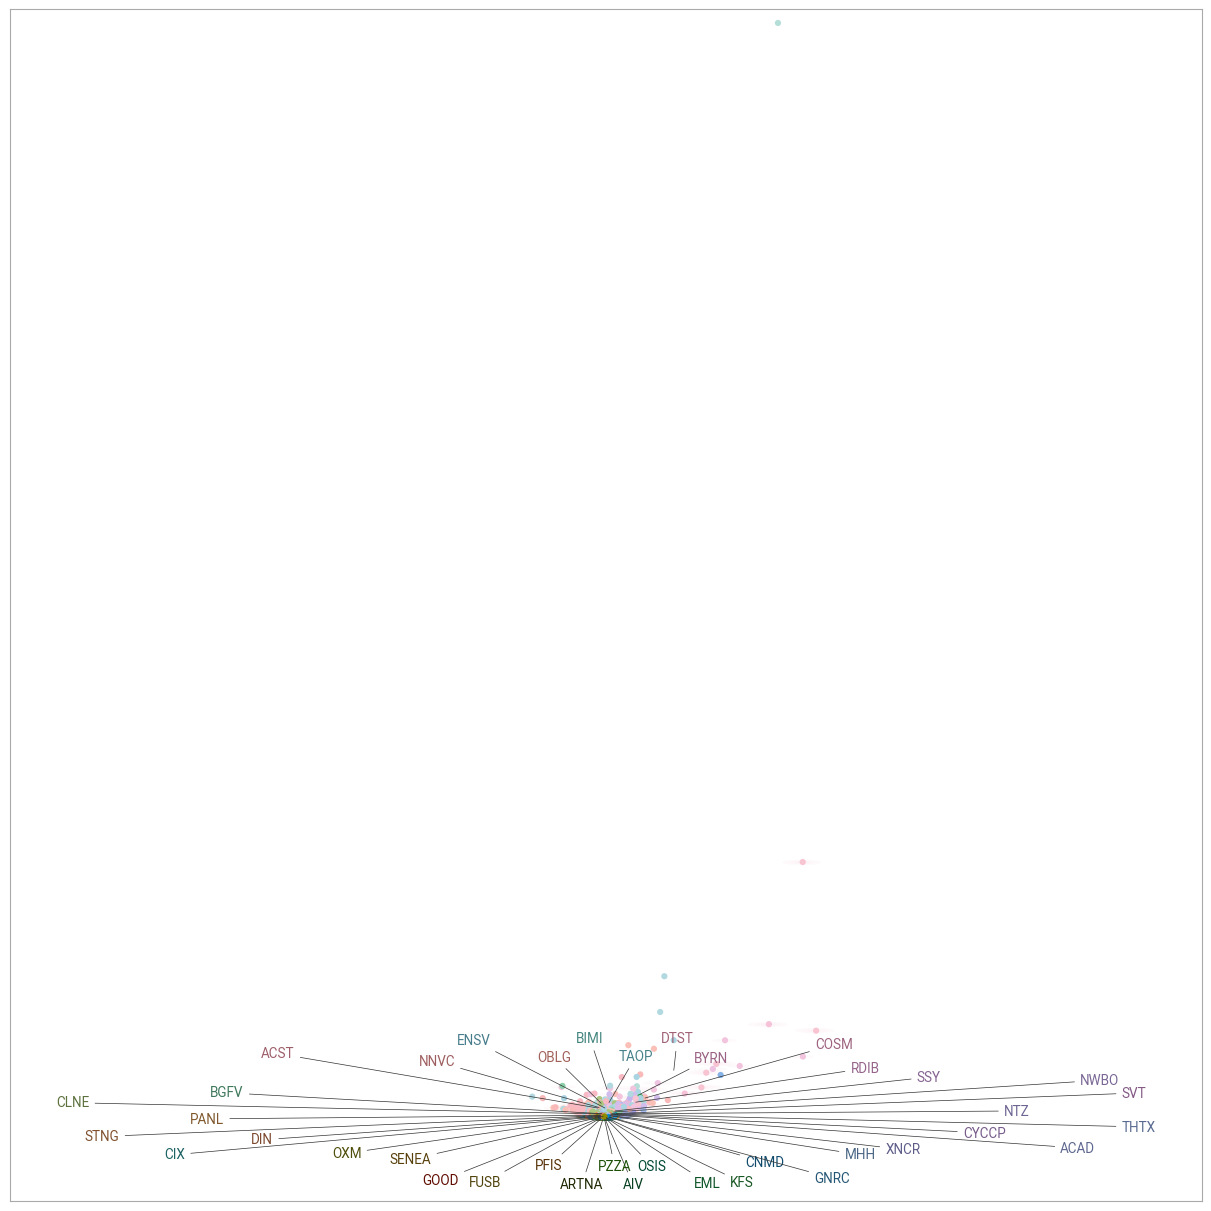

In [24]:
plot_static = datamapplot.create_plot(
    data,
    label,
    point_size=20
    )
plot_static

In [25]:
 plot_interactive = datamapplot.create_interactive_plot(
    data,
    label,
    font_family="Playfair Display SC",
    title="Stock Market Data Visualization",
    hover_text=label,
    width=900,
    height=900,
    enable_search=True,
    darkmode=True,
    initial_zoom_fraction=0.03,
    min_fontsize=14,
    max_fontsize=14
    )
plot_interactive

<InteractiveFigure width=900 height=900>

# Monthly

In [26]:
# Set the date as the index
df_final = df_final.set_index(pd.DatetimeIndex(df_final['date'].values))
#Remove the Date column
df_final.drop(columns=['date'], axis=1, inplace=True)

df_final.head()

ticker,A,AACG,AAL,AAMC,AAME,AAOI,AAON,AAP,AAPL,AAT,...,ZBH,ZBRA,ZD,ZEUS,ZG,ZION,ZTS,ZUMZ,ZWS,ZYXI
2014-01-02,-0.017120,-0.017203,0.004370,-0.007367,-0.026488,-0.025316,-0.008110,-0.008495,-0.014042,-0.005398,...,-0.010190,-0.016642,-0.007404,-0.009313,0.003924,-0.010371,-0.010103,0.008077,0.004043,-0.030702
2014-01-03,0.012633,-0.003044,0.046520,0.001668,0.022360,-0.019139,-0.000382,0.028617,-0.022000,0.015341,...,0.004338,0.007522,0.000615,0.010812,-0.002071,0.007084,-0.009572,-0.002289,0.012158,0.000000
2014-01-06,-0.004937,0.003054,0.018468,-0.014664,-0.011067,-0.001394,-0.016053,-0.009564,0.005446,-0.003137,...,0.006473,-0.003359,-0.002218,-0.006212,0.069834,-0.007034,-0.002189,-0.005736,0.033206,-0.027149
2014-01-07,0.014298,0.017504,-0.004631,0.023453,0.003730,0.028611,0.014450,0.012338,-0.007124,0.011390,...,0.019951,0.010300,0.012721,0.021490,0.032985,0.003060,0.003746,0.023077,0.004591,0.060465
2014-01-08,0.016385,0.009723,0.026972,-0.003216,-0.007433,-0.005427,0.004365,-0.007770,0.006345,-0.017177,...,0.024495,-0.000741,0.013936,-0.015932,-0.014354,0.008734,-0.011197,-0.015789,-0.024915,0.052631


In [27]:
# Resample to weekly data, calculating the mean for each week
monthly_mean = df_final.resample('Q').mean()
monthly_var = df_final.resample('Q').var()

annual_monthly_mean = monthly_mean*4
annual_monthly_var = monthly_var*4

annual_monthly_mean

ticker,A,AACG,AAL,AAMC,AAME,AAOI,AAON,AAP,AAPL,AAT,...,ZBH,ZBRA,ZD,ZEUS,ZG,ZION,ZTS,ZUMZ,ZWS,ZYXI
2014-03-31,-0.000864,0.000581,0.025307,0.013650,-0.006959,0.037851,-0.007847,0.009550,-0.002070,0.005419,...,0.001377,0.017268,0.001031,0.000249,0.007485,0.002802,-0.007450,-0.003811,0.005127,0.025457
2014-06-30,0.002238,0.017141,0.011065,-0.019934,0.004103,-0.001571,0.012989,0.004442,0.012966,0.002049,...,0.006665,0.011683,0.002236,-0.008532,0.033743,-0.002826,0.007232,0.009581,-0.000940,0.022774
2014-09-30,-0.000111,-0.000149,-0.010880,-0.001243,0.003268,-0.020759,-0.016453,-0.001748,0.005678,-0.002391,...,-0.001673,-0.008807,-0.001295,-0.010959,-0.011133,-0.000595,0.008779,0.002104,0.000937,-0.017245
2014-12-31,0.000090,0.004042,0.027919,-0.043158,0.001398,-0.017438,0.018115,0.012906,0.006313,0.012355,...,0.008036,0.006085,0.015055,-0.007148,-0.004016,-0.000727,0.010357,0.021000,0.000137,0.059305
2015-03-31,0.001713,-0.002025,0.000337,-0.018528,0.000364,0.015890,0.006692,-0.003576,0.008719,0.006220,...,0.002810,0.010831,0.004740,-0.015224,-0.001305,-0.002790,0.005247,0.003573,-0.003175,-0.001752
2015-06-30,-0.004350,0.025224,-0.016375,-0.012484,-0.005325,0.016715,-0.004713,0.004346,0.001021,-0.005648,...,-0.004291,0.013756,0.002668,0.020908,-0.008187,0.010762,0.003858,-0.024047,-0.006496,0.029221
2015-09-30,-0.006540,-0.048399,-0.000519,-0.099533,0.007863,0.008348,-0.008795,0.011815,-0.007032,0.003293,...,-0.008949,-0.020068,0.003454,-0.032297,0.005592,-0.007977,-0.009070,-0.027768,-0.020864,0.005975
2015-12-31,0.012895,0.061522,0.006448,-0.004430,0.014381,-0.003450,0.012556,-0.013104,-0.001974,-0.003276,...,0.006039,-0.004514,0.010061,0.013586,-0.005057,0.000192,0.010170,0.000558,0.005044,0.067199
2016-03-31,-0.002496,-0.009230,-0.000998,-0.017390,-0.004644,-0.006216,0.013382,0.004727,0.003351,0.003424,...,0.003101,0.002199,-0.015578,0.030421,0.001117,-0.006423,-0.004332,0.020555,0.008511,-0.012324
2016-06-30,0.007437,-0.005223,-0.021486,0.027364,-0.005140,-0.011695,-0.000069,0.000937,-0.007373,0.004452,...,0.007916,-0.018034,0.002475,0.031059,0.024241,0.003565,0.004867,-0.019032,-0.000917,-0.004507


In [28]:
# Prepare the final DataFrame
result = pd.DataFrame()
tickers = df_final.columns
for ticker in tickers:
    temp_df = pd.DataFrame({
        'Monthly Mean': annual_monthly_mean[ticker],
        'Monthly Variance': annual_monthly_var[ticker]
    })
    temp_df['Ticker'] = ticker
    temp_df = temp_df.reset_index().set_index(['Ticker'])
    result = pd.concat([result, temp_df])

result = result.dropna()
result = result.drop('index',axis=1)
result.reset_index(inplace=True)
result

,Ticker,Monthly Mean,Monthly Variance
0,A,-0.000864,0.001210
1,A,0.002238,0.000481
2,A,-0.000111,0.000502
3,A,0.000090,0.000936
4,A,0.001713,0.000859
...,...,...,...
114395,ZYXI,0.029401,0.004516
114396,ZYXI,-0.005478,0.007853
114397,ZYXI,-0.007236,0.012188
114398,ZYXI,-0.009909,0.003169


In [29]:
df_clusters =

SyntaxError: invalid syntax (<ipython-input-29-7e5a0600df13>, line 1)

In [ ]:
df2 = pd.merge(result, df1, on='Ticker', how='left')
df2

In [ ]:
df2_merged = pd.merge(result, representative_tickers_df, on='Cluster', how='left')
df2_merged